In [268]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
import xgboost as xgb

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from ucimlrepo import fetch_ucirepo 

In [269]:
# Dataset for student outcomes

# Fetch dataset 
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697) 
  
# Data (as pandas dataframes) 
X = predict_students_dropout_and_academic_success.data.features 
y = predict_students_dropout_and_academic_success.data.targets 
  
# Metadata; commenting out because it's a lot!
# This code calling up .metadata is specific to this dataframe,
# would not work in most pandas dataframes
# print(predict_students_dropout_and_academic_success.metadata) 
  
# Variable information
# NOTE: This code works with this dataframe, but typically when
# working in Pandas, one would pull up information on the 
# columns/variables using data_frame_name.info()
print(predict_students_dropout_and_academic_success.variables) 

                                              name     role         type  \
0                                   Marital Status  Feature      Integer   
1                                 Application mode  Feature      Integer   
2                                Application order  Feature      Integer   
3                                           Course  Feature      Integer   
4                       Daytime/evening attendance  Feature      Integer   
5                           Previous qualification  Feature      Integer   
6                   Previous qualification (grade)  Feature   Continuous   
7                                      Nacionality  Feature      Integer   
8                           Mother's qualification  Feature      Integer   
9                           Father's qualification  Feature      Integer   
10                             Mother's occupation  Feature      Integer   
11                             Father's occupation  Feature      Integer   
12          

In [270]:
# The output above makes me think that some integer features should be
# treated as categorical. Let's get some descriptive statistics on the
# features to see if my hunch seems right.
X.describe()
# Looking at Marital Status, we see a maximum of 6, so this is not a binary
# 0/1 feature. Instead it's a categorical feature that we need to set as 
# a category in the data. You can read more about the features (variables)
# here: 
# https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.178571,18.669078,1.727848,8856.642631,0.890823,4.577758,132.613314,1.873192,19.561935,22.275316,...,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969
std,0.605747,17.484682,1.313793,2063.566416,0.311897,10.216592,13.188332,6.914514,15.603186,15.343108,...,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,...,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000
max,6.000000,57.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,...,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


In [271]:
# For simplicity (and fairness -- do we really want to predict
# whether students are going to graduate based on their parents'
# qualifications?), let's drop a most of the categorical features
features_to_drop = [
    "Application mode", 
    "Mother's qualification",
    "Father's qualification",
    "Nacionality",
    "Mother's occupation",
    "Father's occupation",
    "Previous qualification",
    "Course",
]
X = X.drop(columns=features_to_drop)


In [276]:
# We will transform the categorical feature Marital Status into a series of
# a series of columns for each category but one with values of 0s and 1s
# This method drops one of the categories to avoid perfect collinearity
# (redudancy with the columns for the other categories)
X = pd.get_dummies(X, columns=['Marital Status'], drop_first=True)

In [277]:
# Let's look at our simplified data
# Notice the columns for Martial Status
# (with value of 1 missing, that's the reference
# category)
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 32 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Application order                               4424 non-null   int64  
 1   Daytime/evening attendance                      4424 non-null   int64  
 2   Previous qualification (grade)                  4424 non-null   float64
 3   Admission grade                                 4424 non-null   float64
 4   Displaced                                       4424 non-null   int64  
 5   Educational special needs                       4424 non-null   int64  
 6   Debtor                                          4424 non-null   int64  
 7   Tuition fees up to date                         4424 non-null   int64  
 8   Gender                                          4424 non-null   int64  
 9   Scholarship holder                       

In [278]:
# Have 3 categories for the target, but for this demonstration, 
# want just 2
# Recoding Target into 2 labeled and 2 numeric categories
# For numeric categories, 1 = 'Late grad or drop-out'
y_recode = y.copy()
y_recode['TargetLabel'] = np.where(y_recode['Target'] == 'Graduate', 'On-time grad', 'Late grad or drop-out')
y_recode['TargetNumeric'] = np.where(y_recode['Target'] == 'Graduate', 0, 1)

In [279]:
# Set aside 20% of the data as final testing dataset
# TODO: The commented out part below is in case I want
# to encouarge people to build models predicting all 3
# categories on their own at the end
X_modeling, X_test, y_modeling, y_test = train_test_split(
    X, y_recode['TargetNumeric'], test_size=0.20, random_state=55)
# X_modeling, X_test, y_modeling, y_test = train_test_split(
#     X, np.array(y), test_size=0.20, random_state=55)

In [280]:
# Get training and validation data
X_train, X_validate, y_train, y_validate = train_test_split(
    X_modeling, y_modeling, test_size=0.20, random_state=55)

#### Fit the random forest and gradient boost models
The following cells fit the models with default hyperparameters
(not hyperparameters we choose). We only set the random_state
for reproducibility.

Later on, we do what is called hyperparameter tuning, where we
test out different combinations for a select set of the
hyperparameters.

The default hyperparamters that we will be working with during
hyperparamter tuning are as follows:

For gradient boost:
- 'n_estimators': 100
- 'learning_rate': 0.1
- 'max_depth': 3
- For future reference, you can read up on all of the hyperparamters and their defaults for GradientBoostingClassifier here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

For RandomForestClassifier:
- 'max_depth': None
- 'max_features': 'sqrt'
- 'n_estimators': 100
- And here is where you can read up on all of the hyperparameters and their defaults for RandomForestClassfier, for future reference: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html


In [281]:
# Fit a random forest classifier
rand_for = RandomForestClassifier(random_state=55)
rand_for.fit(X_train, y_train)

# Get predictions
rand_for_preds = rand_for.predict(X_validate)

# Print f1 score, classification report
# print('Rand forest f1 score: ', f1_score(rand_for_preds, y_validate, average='macro'))
print('Rand forest f1 score: ', round(f1_score(rand_for_preds, y_validate), 3))
print('Rand forest classification_report: \n', classification_report(rand_for_preds, y_validate))

Rand forest f1 score:  0.8539007092198582
Rand forest classification_report: 
               precision    recall  f1-score   support

           0       0.91      0.81      0.86       377
           1       0.80      0.91      0.85       331

    accuracy                           0.85       708
   macro avg       0.86      0.86      0.85       708
weighted avg       0.86      0.85      0.85       708



In [310]:
# Fit a gradient boosting classifier
grad_boost = GradientBoostingClassifier(random_state=55)
grad_boost.fit(X_train, y_train)

# Get predictions
grad_boost_preds = grad_boost.predict(X_validate)

# Print f1 score, classification report
# TODO: The commented out part below is in case I want
# to encouarge people to build models predicting all 3
# categories on their own at the end
# print('Grad boost f1 score: ', f1_score(grad_boost_preds, y_validate, average='macro'))
print('Grad boost f1 score: ', round(f1_score(grad_boost_preds, y_validate), 3))
print('Grad boost classification report: \n', classification_report(grad_boost_preds, y_validate))

Grad boost f1 score:  0.836
Grad boost classification report: 
               precision    recall  f1-score   support

           0       0.89      0.79      0.84       376
           1       0.79      0.89      0.84       332

    accuracy                           0.84       708
   macro avg       0.84      0.84      0.84       708
weighted avg       0.84      0.84      0.84       708



#### Hyperparameter tune the random forest and gradient boost models

You can go all out hyperparameter tuning and tune for everything. For the sake of demonstrating hyperparameter tuning without making you wait too long for the code to run, below I just select a few hyperparameters with a couple of values to show how to set it up. I am using GridSearch in scikit learn, which tries out all combinations of hyperparameters and selects the best combination according to the selected metric you want to optimize for. A "quicker" version of GridSearch is RandomizedSearchCV, which randomly selects from among combinations to do a good but not exhaustive job of testing out combinations with greater speed. An even "smarter" way to hyperparameter tune is to use a tool like Optuna, which searches for hyperparameter values that do a good job with the metric you are optimizing for and then tries out many more values close to those values to more efficiently find the best combination of values...but Optuna is beyond the scope for these worked examples!

In [299]:
# Hyperparameter tuning for grad boost
# Code adapted from this source:
# https://www.geeksforgeeks.org/how-to-tune-hyperparameters-in-gradient-boosting-algorithm/

# Define the parameter grid for GridSearchCV
param_grid_grad_boost = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2, 0.3],
    'max_depth': [2, 3, 4],
}

# Initialize GridSearchCV
# grid_search_grad_boost = GridSearchCV(estimator=grad_boost, param_grid=param_grid_grad_boost, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search_grad_boost = GridSearchCV(estimator=grad_boost, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)

# Fit the model to the training data using GridSearchCV
grid_search_grad_boost.fit(X_train, y_train)

# Get the best parameters and best model
best_params_grad_boost = grid_search_grad_boost.best_params_
best_model_grad_boost = grid_search_grad_boost.best_estimator_

# Make predictions on the test set using the best model
# The default for GridSearchCV is to update the model grad_boost
# to have the tuned hyperparameters, so the following will
# give predictions from the tuned model now
y_pred_best_grad_boost = best_model_grad_boost.predict(X_validate)

# Evaluate the best model
# TODO: The commented out part below is in case I want
# to encouarge people to build models predicting all 3
# categories on their own at the end
# f1_best_grad_boost = f1_score(y_validate, y_pred_best_grad_boost, average='macro')
f1_best_grad_boost = f1_score(y_validate, y_pred_best_grad_boost)
class_report_best_grad_boost = classification_report(y_validate, y_pred_best_grad_boost)

# Print the results
print("Grad boost best parameters: ", best_params_grad_boost)
print(f"Grad boost best model f1 score:  {round(f1_best_grad_boost, 3)}")
print(f"Grad boost best model classification report: \n{class_report_best_grad_boost}")


Grad boost best parameters:  {'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 100}
Grad boost best model f1 score:  0.8575458392101551
Grad boost best model classification report: 
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       334
           1       0.91      0.81      0.86       374

    accuracy                           0.86       708
   macro avg       0.86      0.86      0.86       708
weighted avg       0.86      0.86      0.86       708



In [305]:
# Hyperparameter tuning for random forest classifier
# Code adapted from this source (though note that I found some errors and other issues):
# https://www.geeksforgeeks.org/random-forest-hyperparameter-tuning-in-python/

# Define the parameter grid for GridSearchCV
param_grid_rand_for = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 2, 3],
}

# Initialize GridSearchCV for random forest classifier
# grid_search_rand_for = GridSearchCV(estimator=rand_for, param_grid=param_grid_rand_for, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search_rand_for = GridSearchCV(estimator=rand_for, param_grid=param_grid_rand_for, cv=5, scoring='f1', n_jobs=-1)

# Fit the model to the training data using GridSearchCV
grid_search_rand_for.fit(X_train, y_train)

# Get the best parameters and best model
best_params_rand_for = grid_search_rand_for.best_params_
best_model_rand_for = grid_search_rand_for.best_estimator_

# Make predictions on the test set using the best model
# The default for GridSearchCV is to update the model grad_boost
# to have the tuned hyperparameters, so the following will
# give predictions from the tuned model now
y_pred_best_rand_for = best_model_rand_for.predict(X_validate)

# Evaluate the best model
# TODO: The commented out part below is in case I want
# to encouarge people to build models predicting all 3
# categories on their own at the end
# f1_best_rand_for = f1_score(y_validate, y_pred_best_grad_boost, average='macro')
f1_best_rand_for = f1_score(y_validate, y_pred_best_rand_for)
class_report_best_rand_for = classification_report(y_validate, y_pred_best_rand_for)

# Print the results
print("Random forest best parameters: ", best_params_rand_for)
print(f"Rand forest best model f1 score:  {round(f1_best_rand_for, 3)}")
print(f"Rand forest best model classification report: \n{class_report_best_rand_for}")


Random forest best parameters:  {'max_depth': None, 'max_features': 'sqrt', 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100}
Rand forest best model f1 score:  0.8539007092198582
Rand forest best model classification report: 
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       334
           1       0.91      0.80      0.85       374

    accuracy                           0.85       708
   macro avg       0.86      0.86      0.85       708
weighted avg       0.86      0.85      0.85       708



#### Discuss what you see!
What do you see when you compare the default models to the tuned models? For each of the two algorithms (gradient boost and random forest):
- Did hyperparamter tuning improve your f1 score?
- If so, by how much?
- What are your reactions to these results? Surprise, confusion, disappointment... ;) 

#### Feature importances

A critique of machine learning is that it can lack transperency. If the goal is to get accurate predictions, then some may not care what the model is doing behind the scenes. But we can add some transperency but pulling up feature importances. These are _not_ the same as parameters you might see in a logistic regression model. Rather, they are values that tell you which features (or predictors or independent variables) were most influential in the predicitons from the model. It isn't possible to get feature importances with every model predicting categories that you run, just so you're aware if you get an error in the future!

Below we pull up feature importances and a data visualization of them from our random forest and boosting models.

In [317]:
# Random forest model feature importances
rand_for_importances = best_model_rand_for.feature_importances_
rand_for_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rand_for_importances
}).sort_values(
    axis=0,
    by='Importance',
    ascending=False
)

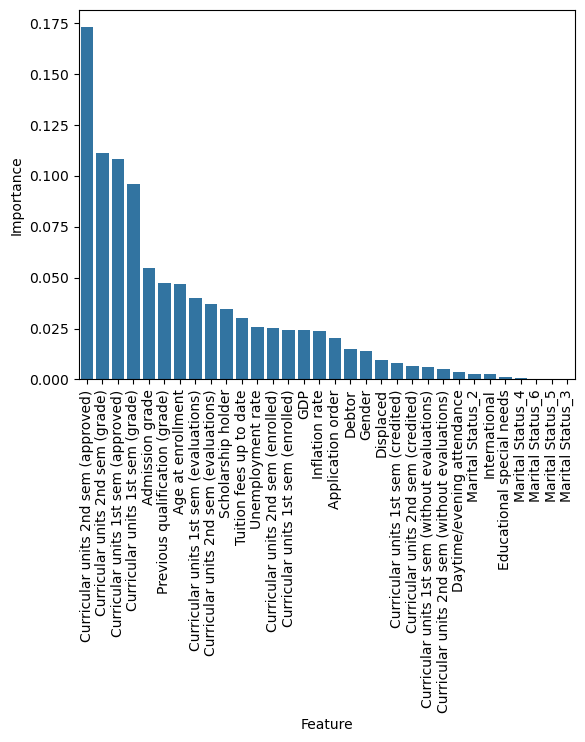

In [318]:
# Creating the data viz
g_rand_for = sns.barplot(rand_for_importances_df, x='Feature', y='Importance')
# Rotating the labels for readability
g_rand_for.tick_params(axis='x', rotation=90)

In [311]:
# Boosting model feature importances
grad_boost_importances = best_model_grad_boost.feature_importances_
grad_boost_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': grad_boost_importances
}).sort_values(
    axis=0,
    by='Importance',
    ascending=False
)

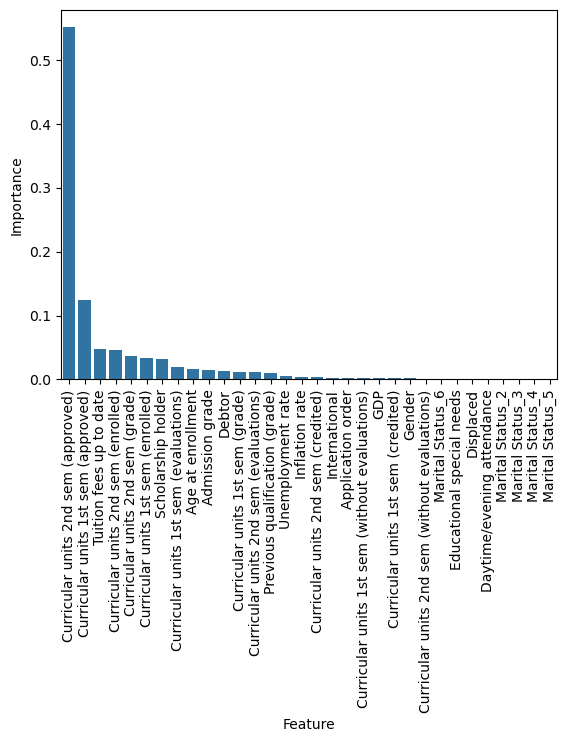

In [315]:
# Creating the data viz
g_boost = sns.barplot(grad_boost_importances_df, x='Feature', y='Importance')
# Rotating the labels for readability
g_boost.tick_params(axis='x', rotation=90)

What does the above tell you about the features that contributed the most to predictions from the random forest and gradient boosting models? Anything that surprised you? Based on these importances, are there features you would leave out of future models for simplicity?

#### The final step!

Once you have done all you plan to do to improve your predictions with your model, you can see how it runs on the "hold out" or "out of bag" data, the data we've never looked at before. We do this because we want as honest a picture as possible of how well the best model we've come up with will do with data the model has never touched before! This is an important step because typically we want a model that will give accurate predictions in real time for students who have not dropped out yet. Thus we want to see how the model performs on data it hasn't "seen" before. In this notebook, we called the "hold out" or "out of bag" data X_test and y_test.

Below, we'll get predictions and then compute the relevant metrics for the unseen data as a final gauge of how well we expect our model to perform in the real world.

In [ ]:
# Getting predictions from hold out data first
y_pred_hold_out_rand_for = best_model_rand_for.predict(X_test)

# Evaluate the best model
f1_hold_out_rand_for = f1_score(y_test, y_pred_hold_out_best_rand_for)
class_report_hold_out_rand_for = classification_report(y_validate, y_pred_hold_out_rand_for)

# Print the results
print(f"Rand forest f1 score from hold out data:  {round(f1_hold_out_rand_for, 3)}")
print(f"Rand forest best model classification report: \n{class_report_hold_out_rand_for}")